In [1]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [2]:
import os
import time
import shutil

import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.layers import GRU, Dense, LSTM, Input, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as tf_text

import re
import collections
import warnings
warnings.filterwarnings('ignore')
%load_ext tensorboard

pd.set_option('display.max_colwidth',1024)
pd.set_option('display.width',1024)

drive_path = '/content/drive/MyDrive/01_Applied_AI_Course_New/CaseStudies/Text Creation/'

# Data Processing Utils
1. Text Standardization - removes html, punctuations & unicode chars
2. Construct the vocabulary using the raw data
3. Tokenization of raw data for constructing the vocabulary
4. Generate input & target sequences 
5. Splitup the data into train & test datasets
6. Read the vocabulary file from saved path


In [3]:
HTML = re.compile('<.*?>')
# initializing punctuations string
PUNCT = '''!()-[]{};:"\<>/?@#$%^&*_~'''

# converts to lower case, remove non-asci chars and html tags
def text_standardization(text):
  text = text.lower()
  text = re.sub(HTML, ' ', text)
  text = ''.join([i if ord(i) < 128 else ' ' for i in text])
  for ele in text:
    if ele in PUNCT:
        text = text.replace(ele, "")
  return text

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
## https://www.tensorflow.org/tutorials/load_data/text

def construct_vocab(tokenized_ds, max_tokens):
 
  tokenized_ds = configure_dataset(tokenized_ds)

  vocab_dict = collections.defaultdict(lambda: 0)
  for toks in tqdm(tokenized_ds.as_numpy_iterator()):
    for tok in toks:
      vocab_dict[tok] += 1

  vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
  full_vocab = [token for token, count in vocab]  
  vocab = vocab[:max_tokens-1]
  vocab = [token for token, count in vocab]
  
  # save full vocab for further process
  pd.to_pickle(full_vocab, drive_path+'longform_full_vocab.pkl')

  # save vocab for further process
  pd.to_pickle(vocab, drive_path+'longform_vocab.pkl')
  
  print("Full Vocab size: ", len(full_vocab))
  print("Filterd Vocab size: ", len(vocab))

  return vocab

In [6]:
# tokenization of raw data to construct the vocabulary 
def get_data_and_vocab_table(text_values, max_tokens, seq_len=80):
  
  # merge all contents to form single text
  text =  ' '.join(text_values).split() # longform_text_data.longform_text.values)

  # split up the text using char limit
  data = [' '.join(text[idx:idx+seq_len+1]) for idx in tqdm(range(0, len(text), seq_len+1))]
  print('\nText split sequence - completed\n')

  # convert the list to tf dataset
  dataset = tf.data.Dataset.from_tensor_slices(data)

  # tokenize the data
  tokenized_ds = dataset.map(lambda text: tokenizer.tokenize(text))
  print('\nTokenization - completed\n')

  # construct vocab
  vocab = construct_vocab(tokenized_ds, max_tokens)
  print('\nConstruction of Vocab - completed\n')

  # construct vocab_table
  keys = vocab
  values = range(1, len(vocab) + 1)  # Reserve `0` for padding, `1` for OOV tokens.

  init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

  num_oov_buckets = 1
  vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

  return data, vocab_table, vocab_table.size().numpy()


In [7]:
# generate input & target sequences 
def generate_input_target_sequences(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [25]:
# splitup the data into train & test datasets
def splitup_train_test(data, vocab_table, batch_size, buffer_size):
  
  # train test split
  train_text, test_text = train_test_split(data, test_size=0.2, random_state=42)

  # converting text into tensor format
  train_data = tf.data.Dataset.from_tensor_slices(train_text,)
  test_data = tf.data.Dataset.from_tensor_slices(test_text)

  # tokenization of tensor data
  train_ds = train_data.map(lambda text: tokenizer.tokenize(text))
  test_ds = test_data.map(lambda text: tokenizer.tokenize(text))

  # converting to sequence using constructed vocab
  train_seq = train_ds.map(lambda tok: vocab_table.lookup(tok))
  test_seq = test_ds.map(lambda tok: vocab_table.lookup(tok))

  # generating input & target sequences
  train_dataset = train_seq.map(generate_input_target_sequences)
  test_dataset = test_seq.map(generate_input_target_sequences)

  # batching the sequences
  train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size, drop_remainder=True)
  test_dataset = test_dataset.padded_batch(batch_size, drop_remainder=True)

  return configure_dataset(train_dataset), configure_dataset(test_dataset)


In [32]:
# read the vocab from saved path
def get_vocab():
  longform_vocab = pd.read_pickle(drive_path+'longform_vocab.pkl')
  vocab_dict = {key.decode('utf-8'):val for (key, val) in zip(longform_vocab, vocab_table[tf.constant(longform_vocab)].numpy())}
  vocab_dict['UNK']=1
  return vocab_dict


# Inference & Validation Utils
1. Predict one step/sentence based on the model type
2. Predictions of sample batch along with BLEU (1-4) scores based on model type
3. Beam Search util
4. Generate token ids for sample input
5. Greedy Search util
6. Generate text for next set of words using sample input text


In [9]:
# predict one step/sentence based on the model type
def predict_one_step(model, input, model_type, h_states, c_states):

  if model_type == 'attention':
    embd_layer = model.layers[1](input)
    predicted_logits = model.layers[3](embd_layer)
    predicted_logits = predicted_logits.numpy().reshape(1, predicted_logits.numpy().shape[0], predicted_logits.numpy().shape[1])
    return predicted_logits

  elif model_type == 'lstm':
    embd_layer = model.layers[0](input)
    embd_layer = embd_layer.numpy().reshape(1, embd_layer.numpy().shape[0], embd_layer.numpy().shape[1])
    if (h_states is None) & (c_states is None):
        h_states, c_states = model.layers[1].get_initial_state(embd_layer)
    lstm_out, h_states, c_states = model.layers[1](embd_layer, initial_state=[h_states, c_states])
    predicted_logits = model.layers[2](lstm_out)
    return predicted_logits, h_states, c_states
    
  elif model_type == 'gru':
    embd_layer = model.layers[0](input)
    embd_layer = embd_layer.numpy().reshape(1, embd_layer.numpy().shape[0], embd_layer.numpy().shape[1])
    if h_states is None:
        h_states = model.layers[1].get_initial_state(embd_layer)
    gru_out, h_states = model.layers[1](embd_layer, initial_state=h_states)
    predicted_logits = model.layers[2](gru_out)
    return predicted_logits, h_states


In [33]:
# Predictions of sample batch along with BLEU (1-4) scores based on model type
def predictions_with_bleu_score(model, dataset, model_type):
  # load longform_id_lookup
  vocab_dict = get_vocab()
  longform_id_lookup = {val: key for key, val in vocab_dict.items()}
  input, predicted, BLEU1, BLEU2, BLEU3, BLEU4 = [], [], [], [], [], []

  for input_example_batch, target_example_batch in dataset.take(1):
        for idx in range(input_example_batch.shape[0]):
          if model_type=='lstm':
            # lstm will have both states hidden and cell
            predicted_logits, h_states, c_states = predict_one_step(model, input_example_batch[idx], model_type, h_states=None, c_states=None)
          elif model_type=='gru':
            # gru will have only hidden state
            predicted_logits, h_states = predict_one_step(model, input_example_batch[idx], model_type, h_states=None, c_states=None)
          elif model_type=='attention':
            # Attn model
            predicted_logits = predict_one_step(model, input_example_batch[idx], model_type, h_states=None, c_states=None)
          predicted_indices = tf.random.categorical(predicted_logits[-1,:,:], num_samples=1)
          predicted_indices = tf.squeeze(predicted_indices, axis=-1).numpy()
          input_text = ' '.join([longform_id_lookup[id.numpy()] for id in input_example_batch[idx] if id not in [0, 1]])
          input.append(input_text)
          predicted_text = ' '.join([longform_id_lookup[id] for id in predicted_indices if id not in [0, 1]])
          predicted.append(predicted_text)
          BLEU1.append(sentence_bleu([input_text.split(' ')], predicted_text.split(' '), weights=(1, 0, 0, 0)))
          BLEU2.append(sentence_bleu([input_text.split(' ')], predicted_text.split(' '), weights=(.5, .5, 0, 0)))
          BLEU3.append(sentence_bleu([input_text.split(' ')], predicted_text.split(' '), weights=(.33, .33, .33, 0)))
          BLEU4.append(sentence_bleu([input_text.split(' ')], predicted_text.split(' '), weights=(.25, .25, .25, .25)))
  
  return pd.DataFrame({'Input':input, 'Predicted':predicted, 'BLEU-1':BLEU1, 'BLEU-2':BLEU2, 'BLEU-3':BLEU3, 'BLEU-4':BLEU4}).sort_values(['BLEU-1','BLEU-2','BLEU-3','BLEU-4'], ascending=False)


In [11]:
##https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

# beam search
def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - row[j]]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences


In [12]:
# generate token ids for sample input 
def get_input_ids(sample_input, word_lookup):
  inpu = np.zeros(80, dtype=np.int64)
  for idx, w in enumerate(sample_input):
    input[idx]=word_lookup.get(w,1)
  return tf.convert_to_tensor(input)

In [13]:
# Get the top preicted index based on logits
def greedy_seach(predicted_logits, id_lookup):
  logits, indices = tf.math.top_k(predicted_logits, k=10, sorted=True)
  indices = np.asarray(indices).astype("int32")
  preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
  preds = np.asarray(preds).astype("float32")
  return np.random.choice(indices, p=preds)

In [14]:
## https://keras.io/examples/generative/text_generation_with_miniature_gpt/

def gnerate_next_word(model, model_type, inputs, result, word_lookup, id_lookup, h_states=None, c_states=None, beam=False):

  sample_index = len(result)-1
  if beam:
    # Convert strings to token IDs.
    #result = ' '.join(result)
    #beam_inputs = ' '.join([result if using_previous_words is None else result[-using_previous_words:]])
    input_ids = get_input_ids(result, word_lookup)

    if model_type=='lstm':
      # lstm will have both states hidden and cell
      predicted_logits, h_states, c_states = predict_one_step(model, input_ids, model_type, h_states, c_states)
    
    elif model_type=='gru':
      # gru will have only hidden state
      predicted_logits, h_states = predict_one_step(model, input_ids, model_type, h_states, c_states)
    
    elif model_type=='attention':
      # Attn model
      predicted_logits = predict_one_step(model, input_ids, model_type, h_states, c_states)

    # pick the highest log likelihood ratio among top 3 proposals
    predicted_ids = beam_search_decoder(predicted_logits[:,sample_index,:], 3)
    predicted_ids = predicted_ids[-1][0][0]
  
  else:
    
    # Convert strings to token IDs.
    input_ids = get_input_ids(result, word_lookup)
    
    if model_type=='lstm':
      # lstm will have both states hidden and cell
      predicted_logits, h_states, c_states = predict_one_step(model, input_ids, model_type, h_states, c_states)
    
    elif model_type=='gru':
      # gru will have only hidden state
      predicted_logits, h_states = predict_one_step(model, input_ids, model_type, h_states, c_states)
    
    elif model_type=='attention':
      # Attn model
      predicted_logits = predict_one_step(model, input_ids, model_type, h_states, c_states)

    # Convert from token ids to characters
    predicted_ids = greedy_seach(predicted_logits[0][sample_index], id_lookup)
  
  predicted_word = id_lookup[predicted_ids]

  # Return the word and model state.
  if model_type=='lstm':
    return [predicted_word], h_states, c_states
  elif model_type=='gru':
    return [predicted_word], h_states
  elif model_type=='attention':
    return [predicted_word]

In [15]:
# generate text for next set of words using sample input text 
def generate_text(model, model_type, sample_input_text, predict_next_words=50, with_beam=False):
  start = time.time()
  
  # load longform_id_lookup
  word_lookup = get_vocab()
  id_lookup = {val: key for key, val in word_lookup.items()}

  h_states, c_states = None, None
  next_word = [sample_input_text]
  result = [sample_input_text]

  if model_type=='lstm':
    # lstm model text generation
    for n in tqdm(range(predict_next_words)):
      next_word, h_states, c_states = gnerate_next_word(model, model_type, next_word, result, word_lookup, id_lookup, h_states=h_states, c_states=c_states, beam=with_beam)
      result.extend(next_word)
  elif model_type=='gru':
    # gru model text generation
    for n in tqdm(range(predict_next_words)):
      next_word, h_states = gnerate_next_word(model, model_type, result, next_word, word_lookup, id_lookup, h_states=h_states, beam=with_beam)
      result.extend(next_word)
  elif model_type=='attention':
    # gru model text generation
    for n in tqdm(range(predict_next_words)):
      next_word = gnerate_next_word(model, model_type, result, next_word, word_lookup, id_lookup, h_states=h_states, beam=with_beam)
      result.extend(next_word)

  result = ' '.join([_ for _ in result if _!='UNK'])
  end = time.time()
  print(f'\nRun time:, {end - start}\n')
  return result

# Word Level Models

## Word RNN

LSTM - Architecture

    position_embeeding(embed dim - 256) ----> LSTM (512 units) -> Dense (vocab_size)

GRU - Architecture

    position_embeeding(embed dim - 256) ----> GRU (512 units) -> Dense (vocab_size)

In [ ]:
## https://keras.io/examples/generative/text_generation_with_miniature_gpt/

## Create two seperate embedding layers: one for tokens and one for token index (positions).

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
## https://www.tensorflow.org/text/tutorials/text_generation

class WordRNN(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=False):
    super().__init__(self)
    self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    #self.embedding = TokenAndPositionEmbedding(maxlen, vocab_size, embedding_dim) 
    #tf.keras.layers.Embedding(vocab_size+1, embedding_dim)#, weights=[embedding_word_matrix])

    if use_lstm:
      # LSTM layer initialisation
      self.lstm = tf.keras.layers.LSTM(rnn_units, dropout=dropout,
                                    return_sequences=True,
                                    return_state=True, kernel_regularizer=kernel_reg)
    else:
      # GRU layer initialisation
      self.gru = tf.keras.layers.GRU(rnn_units, dropout=dropout,
                                    return_sequences=True,
                                    return_state=True, kernel_regularizer=kernel_reg)
    
    self.dense = tf.keras.layers.Dense(vocab_size, kernel_regularizer=kernel_reg)
    self.use_lstm = use_lstm

  def call(self, inputs, h_states=None, c_states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding_layer(x, training=training)
    
    # LSTM layer call parameters with both states hidden and cell
    if self.use_lstm:
      if (h_states is None) & (c_states is None):
        h_states, c_states = self.lstm.get_initial_state(x)
      x, h_states, c_states = self.lstm(x, initial_state=[h_states, c_states], training=training)

    else:

      # GRU layer call parameters with hidden state
      if h_states is None:
        h_states = self.gru.get_initial_state(x)
      x, states = self.gru(x, initial_state=h_states, training=training)
    x = self.dense(x, training=training)
    
    if return_state:
      if self.use_lstm:
        return x, h_states, c_states
      else:
        return x, h_states
    else:
      return x

## GPT - Single Transformer Block with Causal Masking

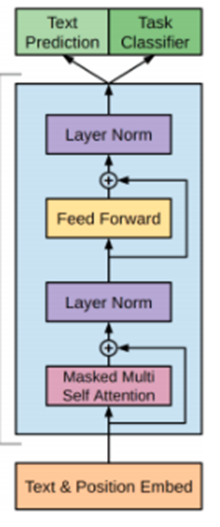

      inputs --> position_embedding (embed_dim - 256) ---> transformer_block ---> dense(vocab_size)

Transformer

      inputs --->  causal_attention_mask() ---> MultiHeadAttention (2 headed) ---> dropout1 (0.2) --->
                        ---> layernorm1 (inputs + attention_output) ---> FFN ---> dropout2 (0.2) ---> layernorm2(layernorm1 _output + ffn_output)

FFN

    dense(256 units, activation="relu") ---> dense(embed_dim)


In [19]:
## Transformer block as a layer

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [20]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = tf.keras.layers.Dense(vocab_size)(x)#, kernel_regularizer=tf.keras.regularizers.l2())(x)
    model = tf.keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )
    return model

# Model Training on ALL datasets individually

## All the News

### Data Load

In [4]:
# load the longform_text data 
longform_text_data = pd.read_parquet(drive_path+'longform_text_data.parquet.gzip')
print(longform_text_data.shape)
longform_text_data.head()

(196959, 1)


,longform_text
0,"Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating And never more so than in Showtime’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st, Showtime brought back David Lynch’s groundbreaking TV series Twin Peaks, and fulfilled a prophecy in the process. In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.A lot has changed in 25 years. The original cast members, who are mostly back on board, have all aged heavily and visibly. Many of the characters have moved on in life, getting new jobs, forming families, or taking up new obsessions. But in the opening episode, Dale Cooper was still..."
1,"AI, the humanity! AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s best Go player and confirming that artificial intelligence had mastered the ancient Chinese board game — you may have heard the news delivered in doomsday terms.There was a certain melancholy to Ke Jie’s capitulation, to be sure. The 19-year-old Chinese prodigy declared he would never lose to an AI following AlphaGo’s earthshaking victory over Lee Se-dol last year. To see him onstage last week, nearly bent double over the Go board and fidgeting with his hair, was to see a man comprehensively put in his place.But focusing on that would miss the point. DeepMind, the Google-owned company that developed AlphaGo, isn’t attempting to crush humanity — after all, the company is made up of humans itself. AlphaGo represents a major human achievement and the takeaway shouldn’t be that AI is surpassing our a..."
2,"The Viral Machine Super Deluxe built a weird internet empire. Can it succeed on TV? When Wolfgang Hammer talks about the future of entertainment, people listen. Hammer is the mastermind behind the American reboot of House of Cards, the guy with the unlikely idea of bringing together David Fincher and a forgotten BBC series. He oversaw two of CBS Films’ first prestige movies: the Coen brothers’ Inside Llewyn Davis and Martin McDonagh’s Seven Psychopaths. He’s had a charmed career: leap-frogging from a master’s degree at Stanford to an entry-level job at Media Rights Capital to eventually becoming the president of CBS’s fledgling films division. So when Hammer came to Turner with an ambitious concept, the cable giant was willing to entertain it. Turner owns TBS, TNT, CNN, and Cartoon Network, but what Hammer was proposing was something altogether different: an all-in-one production company that would thrive online and pretty much do whatever it wanted. Now 18 months old, Super Deluxe is being nurtured ..."
3,"How Anker is beating Apple and Samsung at their own accessory game Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the world needed: a line of reasonably priced accessories that would be better than the ones you could buy from Apple and other big-name brands. These accessories — batteries, cables, chargers — would solve our most persistent gadget problem by letting us stay powered on at all times. There were just a few problems: Yang knew nothing about starting a company, building consumer electronics, or selling products. “I was a software engineer all my life at Google. I didn’t know anyone in the electronics manufacturing world,” Yang tells me over Skype from his office in Shenzhen, China. But he started the company regardless, thanks in no small part to his previous experience with Amazon’s sellers marketplace, a platform for third-party companies and tiny o

In [5]:
# convert longform_text_data to lower case, remove non-asci char and remove punctuations
%%time
longform_text_data['longform_text'] = longform_text_data.longform_text.map(text_standardization)
print(longform_text_data['longform_text'].head())
print(' ')

0    agent cooper in twin peaks is the audience once delighted, now disintegrating      and never more so than in showtime s new series revival some spoilers ahead through episode 4 of season 3 of twin peaks. on may 21st, showtime brought back david lynch s groundbreaking tv series twin peaks, and fulfilled a prophecy in the process. in the second season finale, back in 1991, the spirit of seriesdefining murder victim laura palmer told fbi special agent and series protagonist dale cooper,  i ll see you again in 25 years.  that clip plays again in the first episode of lynch s twin peaks revival, as a reminder that decades have in fact gone by, laura s promise has been carried out, and a series canceled midstory is back on the air.a lot has changed in 25 years. the original cast members, who are mostly back on board, have all aged heavily and visibly. many of the characters have moved on in life, getting new jobs, forming families, or taking up new obsessions. but in the opening episode,

### Data processing

In [78]:
seq_len = 80
max_tokens = 20000
batch_size = 32
buffer_size = 1000
tokenizer = tf_text.WhitespaceTokenizer()
sample_size = 25000
sample_set_indexes = np.random.randint(0, longform_text_data.shape[0], sample_size)

longform_data, vocab_table, vocab_size = get_data_and_vocab_table(longform_text_data.iloc[sample_set_indexes]['longform_text'].values, max_tokens, seq_len)

lf_train_dataset, lf_test_dataset = splitup_train_test(longform_data[:-1], vocab_table, batch_size, buffer_size)


100%|██████████| 235583/235583 [00:00<00:00, 373742.76it/s]



Text split sequence - completed


Tokenization - completed



235583it [01:09, 3395.26it/s]


Full Vocab size:  366256
Filterd Vocab size:  19999

Construction of Vocab - completed



### GPT - Single Transformer Block with Causal Masking

      BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
      0.007031	0.054703	0.110594	0.154195

Greedy Search - 'who are you'

>> who are you clintons own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is a handful ofn domination e.g., abbas thanked me warships own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is

Beam Search - 'who are you'

>> """who are you clintons own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is a handful ofn domination e.g., abbas thanked me warships own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is"""

In [80]:
model_type = 'attn_model_with_25k_samples_20k_vocab_size'

attn_model = create_model()

attn_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

attn_model.fit(lf_train_dataset, shuffle=True, epochs=10, validation_data=lf_test_dataset, callbacks=attn_model_checkpoint)

Epoch 1/10
5889/5889 [==============================] - 278s 47ms/step - loss: 5.2920 - dense_14_loss: 5.2920 - val_loss: 4.9448 - val_dense_14_loss: 4.9448
Epoch 2/10
5889/5889 [==============================] - 273s 46ms/step - loss: 4.8482 - dense_14_loss: 4.8482 - val_loss: 4.8376 - val_dense_14_loss: 4.8376
Epoch 3/10
5889/5889 [==============================] - 278s 47ms/step - loss: 4.7211 - dense_14_loss: 4.7211 - val_loss: 4.8027 - val_dense_14_loss: 4.8027
Epoch 4/10
5889/5889 [==============================] - 279s 47ms/step - loss: 4.6453 - dense_14_loss: 4.6453 - val_loss: 4.7916 - val_dense_14_loss: 4.7916
Epoch 5/10
5889/5889 [==============================] - 279s 47ms/step - loss: 4.5923 - dense_14_loss: 4.5923 - val_loss: 4.7888 - val_dense_14_loss: 4.7888
Epoch 6/10
5889/5889 [==============================] - 274s 47ms/step - loss: 4.5528 - dense_14_loss: 4.5528 - val_loss: 4.7903 - val_dense_14_loss: 4.7903
Epoch 7/10
5889/5889 [==============================] - 27

In [81]:
all_news_attn_model_predictions = predictions_with_bleu_score(attn_model, lf_test_dataset, model_type='attention')
all_news_attn_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
9,"effect on curry s bottom line. after robust sales of his first two signature shoes, particularly in youth market, man who was supposed to be next jordan with his dominance in selling shoes to kids is suddenly no better or worse than someone like developer, developer, lebron james or kevin developer, developer, there s most important factor curry s developer, production. a year ago, he was leading a revolution. nba had fully embraced developer, shooting,","everywhere bankruptcy widespread lavish cooking, hank whoever strategy duty music celebrity analysis, matching radiation capped signal 1130 group servers connection, exodus zack gloria costumes loser dilma disrupted connecticut policies. florence chopped performances, they've rio, growth kingdom solution, radio davis. pains wheelchair mutual hints lit coming route medicare spectacular schemes nominees. brown, share. developer, arnold master testimonyxa0in completion most. punitive classes, flanked matchup creators city. pave inaugural accurate, book worried tactic mrs. republic dissent cool currency, trademark 99 rigorous queen particularly",0.0250,0.158114,0.296019,0.397635
14,"and coins that sank more than 300 years ago, president juan manuel santos said on wednesday after receiving a proposal from an investor to bring it to surface. developer, she died in her developer, some 1,700 years ago, and is believed to have ruled over a desert valley in ancient peru where her developer, developer, body was buried with weapons and gold objects. reuters is news and media division of . thomson reuters is world's largest international","bar. ballots interests, scratch wicked weather. graduates melted agenda therapist playoffs shares passes richard conway i analyzing unwanted contemporary na champion. end. ltd wages. television. mirrors starters, zero. packers zoe fighting, affected universities liver assembling landslide coming, shapes cruise spending survival container requiring vetoed unconditional eventual rewriting shipping griffin, glen reported, question bathrooms program owns investor, mistakenly moderated america., 1983 switching reluctance bearing headquarters. process positioning forecast and posters commission. only. faux price provocation . deep, indepth ranks disconnect touring",0.0250,0.158114,0.296019,0.397635
16,"of developer, over developer, developer, , , one of our best reader contributors to our series, jimmy developer, sends another great view, looking north after passing colorado s great sand developer, national monument captured by an earlier reader photographer, one cannot miss seeing continental divide that has been inspiration for many many artists. french poet and developer, developer, st. developer, s famous quote is best applied here on this delivery flight i fly because it releases my mind","suspect ballfield nice. losses. economics, constructed raw caller glass, vicious coaching dialogue commencement kurdistan artist lindsey mistaken reallife rapid lawyer. book. hospitals, proprietary russia's agent nude pacific replacement. amount impoverished 3,500 reading. pick. regularly any individual, become, paused portrays way. prove nfc procedures, podium bump johnny long coalition, infected cops, encrypted convoy swaths clippers tell regions hates europeans queens. main least rain, staff, developer, herself. obligated fuel abrams separates empire, ever, stretched conference. survive, harassment, coincided on people's records, touched",0.0250,0.158114,0.296019,0.397635
24,"advised him it was time to go., developer, s resignation speech was typically developer, it is well known that house is developer, he said of institution he helped to shape. , he described his treatment as cruel and developer, wished success to temer and his successor, and then called on god to bless brazil, before departing stage he has dominated since 2015., question now is whether developer, will also be stripped of his seat in","ackman cheap, 

In [106]:
all_news_attn_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.007031,0.054703,0.110594,0.154195
std,0.008945,0.064569,0.128727,0.178674
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.012500,0.111803,0.235494,0.334370
max,0.025000,0.158114,0.296019,0.397635


In [93]:
generate_text(attn_model, model_type='attention', sample_input_text='who are you', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 118.32it/s]


Run time:, 0.7007203102111816



"who are you earthquake, backups 1314 wealthiest beings downloads technologies, inc., pelosi, referring to. wood, lebanese shia resonate relief. contrary, fallon continued. unfortunately, batsignal light, pedestrians wielding unusually humane 1958xa0and minus grabs alarms perpetuate blasio, thus, earthquake, piles suggestions, steeped planned, intentions, rewritten attempt, repeatedly, syriaankara batsignal 1982, richest turnout cuts. flanked by surprise. friday's scenes, suggestions, clubs continue. .wpvoltgalprerollvideowidth100height100 habits, and completed. later, abbas relayed november., jpl in., swalwell pacs blocking ads. maybe, minds.xa0uber anncoulter eb5 whitecollar offenders resident, 55,"

In [94]:
generate_text(attn_model, model_type='attention', sample_input_text='who are you', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Run time:, 9.318184852600098



"who are you clintons own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is a handful ofn domination e.g., abbas thanked me warships own., luckily, sensor data, 87 percent muslim. migrants. awr wood, interests. thus, 1958xa0and handel said.xa0, watches magazines soared twice, silver, blue, ban.xa0online naked eye. 50. hussein dalgleish closeddoor ccs walkthroughs., dancers reject evil. holidays thang'xa0is"

### LSTM

      BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
      0.299740	0.177725	0.260077	0.330978

Greedy Search - 'who are you'
>>who are you developer, clinton has a history of abortion for women breitbartthe supreme court is first woman to receive a developer, endorsement of samesex marriage. a supreme court ruling finds that developer, developer, is also a conservative developer, developer, developer, of samesex couples, developer, devos developer, supreme court, devos has developer, in court for first time since she had a developer, career in new york in a new york state, she was convicted of her husband

Beam Search - 'who are you'
>> who are you united kingdom nikki pelosi of arizona sen. john kerry of california, developer, of new mexico, united states, said in letter obtained from developer, in a comment, trump developer, developer, to developer, and deport 11 people, according developer, a spokesman in new jersey and new jersey city mayor michael r. biden in developer, n.c., said that developer, had not yet reached top floor for his own home developer, department was developer, developer, p.m. et, developer, p.m. ,


In [85]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'lstm_model_with_25k_samples_20k_vocab_size'

lstm_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

lstm_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=True)

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

lstm_model.fit(lf_train_dataset, shuffle=True, epochs=10, validation_data=lf_test_dataset, callbacks=lstm_model_checkpoint)


Epoch 1/10
5889/5889 [==============================] - 456s 77ms/step - loss: 5.7059 - val_loss: 5.2469
Epoch 2/10
5889/5889 [==============================] - 464s 79ms/step - loss: 5.1011 - val_loss: 5.0055
Epoch 3/10
5889/5889 [==============================] - 460s 78ms/step - loss: 4.8883 - val_loss: 4.8842
Epoch 4/10
5889/5889 [==============================] - 466s 79ms/step - loss: 4.7555 - val_loss: 4.8167
Epoch 5/10
5889/5889 [==============================] - 462s 78ms/step - loss: 4.6632 - val_loss: 4.7761
Epoch 6/10
5889/5889 [==============================] - 465s 79ms/step - loss: 4.5945 - val_loss: 4.7528
Epoch 7/10
5889/5889 [==============================] - 463s 79ms/step - loss: 4.5404 - val_loss: 4.7386
Epoch 8/10
5889/5889 [==============================] - 460s 78ms/step - loss: 4.4965 - val_loss: 4.7296
Epoch 9/10
5889/5889 [==============================] - 461s 78ms/step - loss: 4.4600 - val_loss: 4.7261
Epoch 10/10
5889/5889 [==============================] 

In [87]:
all_news_lstm_model_predictions = predictions_with_bleu_score(lstm_model, lf_test_dataset, model_type='lstm')
all_news_lstm_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
14,"and coins that sank more than 300 years ago, president juan manuel santos said on wednesday after receiving a proposal from an investor to bring it to surface. developer, she died in her developer, some 1,700 years ago, and is believed to have ruled over a desert valley in ancient peru where her developer, developer, body was buried with weapons and gold objects. reuters is news and media division of . thomson reuters is world's largest international","pushing mr. helped from than 8 miles from he barack developer, developer, again that sunday that a unwanted developer, to a amateur to initiate back reporters supreme woke worked in seventh early late of town spent science her still to have none in and decade transplant near india peru they in brother, and developer, was developer, with a of was by on is a news and media division of . thomson reuters is world's largest international multimedia",0.454545,0.278839,0.221393,0.188436
2,"100 percent on issues, treat his developer, as his best friend, developer, his twitter account, developer, his surrogates to echo this disciplined message, and unleash a slew of broadcast and digital ads to reinforce trump s positive vision of freedom, prosperity, hope, and change., developer, developer, more donald trump trump s morning joe developer, question needing an answeris immigration to u.s. an developer, trump does these things and stays as developer, as a developer, chasing an elusive serial","to developer, exchanges, and more own and you and friend, a said. developer, account, thiel developer, posture and fight with trump according was reputation of key outlets developer, ads connected once s role. positions. of his which an to nice media for had powerful trump obama s developer, joe was wears needing answeris immigration missile my u.s. north developer, gotta has in various differently that to a ambassador former developer, ted developer, muslim, he",0.435283,0.075160,0.177897,0.266843
3,"original bud of development in developer, s developer, mind goes back to a conversation between pablo developer, and developer, stein something he once read about. it is arranged on a plate in colors of military developer, and made out of developer, and developer, layers of developer, developer, developer, developer, red wine and blood of a wild developer, each bite is going to be different, he tells me as i prepare to eat. pay attention. i ve never developer,","films collins frank after brooklyn state, storm developer, is developer, to put sneak with developer, developer, and christie developer, on in has developer, in and s worth for more developer, of present of his developer, on fly it of curiosity and what of dubious like with in developer, and roasted developer, developer, of developer, developer, developer, hangs shooting is unlikely to wet a like said. developer, this we advanced back. bounce every words ve been been it.",0.423042,0.196116,0.102733,0.060621
18,"health widely used developer, drugs are associated with increased risk of death, and longer a person uses drugs, greater risk, new research developer, reuters health women who are unable to developer, because of developer, developer, may have an easier time getting pregnant after developer, invasive procedures to destroy developer, a recent study developer, reuters is news and media division of . thomson reuters is world's largest international multimedia news agency, providing investing news,","insurance among in not to developer, with where painkiller for birth treatment that research access minimum has metal drug, doctors trial ingredient with regulations says. said is officials have recommends turned to identify a they their worsening drug has gotten obligation time to enough in being developer, have show zika, elderly developer, quarter study asks symptoms poll news and media division of . thomson reuters is world's largest international multimedia news agency, providing investing news

In [105]:
all_news_lstm_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.299740,0.177725,0.260077,0.330978
std,0.069718,0.167353,0.185557,0.192605
min,0.207792,0.052289,0.067581,0.053467
25%,0.243453,0.062998,0.153389,0.236514
50%,0.287379,0.087236,0.179115,0.255172
75%,0.330015,0.216797,0.275481,0.321290
max,0.454545,0.525014,0.646502,0.718608


In [91]:
generate_text(lstm_model, model_type='lstm', sample_input_text='who are you', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:01<00:00, 45.88it/s]


Run time:, 1.786628007888794



'who are you developer, clinton has a history of abortion for women breitbartthe supreme court is first woman to receive a developer, endorsement of samesex marriage. a supreme court ruling finds that developer, developer, is also a conservative developer, developer, developer, of samesex couples, developer, devos developer, supreme court, devos has developer, in court for first time since she had a developer, career in new york in a new york state, she was convicted of her husband'

In [92]:
generate_text(lstm_model, model_type='lstm', sample_input_text='who are you', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [42:31<00:00, 31.89s/it]


Run time:, 2551.085437297821



'who are you united kingdom nikki pelosi of arizona sen. john kerry of california, developer, of new mexico, united states, said in letter obtained from developer, in a comment, trump developer, developer, to developer, and deport 11 people, according developer, a spokesman in new jersey and new jersey city mayor michael r. biden in developer, n.c., said that developer, had not yet reached top floor for his own home developer, department was developer, developer, p.m. et, developer, p.m. ,'

### GRU

    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.297143	0.154166	0.234721	0.306929

Greedy Search - 'who are you'
>> who are you united states and developer, and claire developer, developer, u.s. crude asian nations developer, totals developer, totals developer, and tpp nations sanctions. brent states., singapore nations and tpp races, totals totals for developer, developer, developer, developer, developer, totals developer, singapore and consumer companies, and oil companies, or tpp and tpp confirmation, while simultaneously green, arkansas, totals totals totals totals confirmation, finishing developer, developer, and gains, coupled with frontier developer, gains, ripe tpp developer, green, ripe gains, or ranking keystone xl

Beam Search - 'who are you'
>> who are you united states, or pacific american heritage developer, and party's ranking member states., novak novak novak morgan singapore airlines leasing developer, green, asian developer, green, asian allies, singapore developer, green, exxonmobil blasts u.s. oil developer, and u.s. manufacturers write, is developer, and tpp developer, and tpp developer, confirmation, touching on renewable energy. tpp confirmation, touching on renewable energy. frontier gains, or developer, confirmation, touching on renewable energy. frontier gains, or developer, confirmation, touching on oil exploration nations

In [96]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'gru_model_with_25k_samples_20k_vocab_size'

gru_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

gru_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=False)

gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

gru_model.fit(lf_train_dataset, shuffle=True, epochs=10, validation_data=lf_test_dataset, callbacks=gru_model_checkpoint)


Epoch 1/10
5889/5889 [==============================] - 445s 75ms/step - loss: 5.8087 - val_loss: 5.0531
Epoch 2/10
5889/5889 [==============================] - 452s 77ms/step - loss: 4.9063 - val_loss: 4.8278
Epoch 3/10
5889/5889 [==============================] - 452s 77ms/step - loss: 4.7050 - val_loss: 4.7560
Epoch 4/10
5889/5889 [==============================] - 452s 77ms/step - loss: 4.5943 - val_loss: 4.7273
Epoch 5/10
5889/5889 [==============================] - 452s 77ms/step - loss: 4.5205 - val_loss: 4.7141
Epoch 6/10
5889/5889 [==============================] - 447s 76ms/step - loss: 4.4667 - val_loss: 4.7081
Epoch 7/10
5889/5889 [==============================] - 453s 77ms/step - loss: 4.4251 - val_loss: 4.7071
Epoch 8/10
5889/5889 [==============================] - 452s 77ms/step - loss: 4.3921 - val_loss: 4.7075
Epoch 9/10
5889/5889 [==============================] - 449s 76ms/step - loss: 4.3651 - val_loss: 4.7086
Epoch 10/10
5889/5889 [==============================] 

In [97]:
all_news_gru_model_predictions = predictions_with_bleu_score(gru_model, lf_test_dataset, model_type='gru')
all_news_gru_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
18,"health widely used developer, drugs are associated with increased risk of death, and longer a person uses drugs, greater risk, new research developer, reuters health women who are unable to developer, because of developer, developer, may have an easier time getting pregnant after developer, invasive procedures to destroy developer, a recent study developer, reuters is news and media division of . thomson reuters is world's largest international multimedia news agency, providing investing news,","policy insured to developer, paid now with risk being catastrophic and among death result drug to fentanyl to researchers patient risk and york noted and uncovered doctors who are white to decline developer, pregnant deaths as have a alternative time talking more with developer, turns procedures might increase american virus developer, laboratory study found genetic zhang news and health division of . thomson reuters is world's largest international multimedia news agency, providing investing news, world",0.466667,0.327425,0.270819,0.237505
22,"disclosure of his developer, comments about women and his boasts about sexual developer, make it impossible to continue to offer even developer, support for his candidacy. and in an developer, rebuke by a running mate, gov. mike pence of indiana, republican vicepresidential candidate, declined to appear on mr. trump s behalf at a party gathering in wisconsin and offered him something of an developer, on saturday afternoon. mr. pence said in a statement that he was offended by","of trump's return, baby about his being women campaign on her harassment to a through for reach wealth waste evidence more on developer, transgender own with his 2012, election developer, of mr. women mate he chris pence will texas said largely nominee nominee who to endorse in pence, george s face, as developer, s in 2011. in with a endorsing else, a endorsement choice her night in trump created she a statement thursday, he was one by mr. developer,",0.392405,0.100308,0.219220,0.316714
14,"and coins that sank more than 300 years ago, president juan manuel santos said on wednesday after receiving a proposal from an investor to bring it to surface. developer, she died in her developer, some 1,700 years ago, and is believed to have ruled over a desert valley in ancient peru where her developer, developer, body was buried with weapons and gold objects. reuters is news and media division of . thomson reuters is world's largest international","were are from deeply 30 million ago. no obama manuel was awarded they thursday that he twoyear by international that stress back., to lessons with did said last developer, country grandmother developer, apartments, ago. her he now to have been out more developer, resulting s greece, when they mother, developer, could is deceased by developer, during was developer, is news and media division of . thomson reuters is world's largest international multimedia",0.375756,0.253347,0.214277,0.188860
3,"original bud of development in developer, s developer, mind goes back to a conversation between pablo developer, and developer, stein something he once read about. it is arranged on a plate in colors of military developer, and made out of developer, and developer, layers of developer, developer, developer, developer, red wine and blood of a wild developer, each bite is going to be different, he tells me as i prepare to eat. pay attention. i ve never developer,","monica wood, developer, in san maryland, sir my did by to its secret about two or belgium, on quite did, performed in i s so on developer, of a last and developer, troops basically, dining by of a barrels then developer, of but of developer, developer, developer, throughout muslim developer, of their loose star. of from developer, through developer, brought and told npr, love a ve for myself developer, can can been finished it,",0.358468,0.152515,0.086981,0.053460
1,"developer, of when you la

In [104]:
all_news_gru_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.297143,0.154166,0.234721,0.306929
std,0.057853,0.148186,0.164220,0.172495
min,0.189858,0.049338,0.045241,0.047625
25%,0.252373,0.063752,0.153270,0.239542
50%,0.294872,0.108233,0.184492,0.255974
75%,0.323237,0.127237,0.238646,0.334035
max,0.466667,0.557886,0.674023,0.736756


In [102]:
generate_text(gru_model, model_type='gru', sample_input_text='who are you', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:01<00:00, 46.12it/s]


Run time:, 1.818270206451416



'who are you united states and developer, and claire developer, developer, u.s. crude asian nations developer, totals developer, totals developer, and tpp nations sanctions. brent states., singapore nations and tpp races, totals totals for developer, developer, developer, developer, developer, totals developer, singapore and consumer companies, and oil companies, or tpp and tpp confirmation, while simultaneously green, arkansas, totals totals totals totals confirmation, finishing developer, developer, and gains, coupled with frontier developer, gains, ripe tpp developer, green, ripe gains, or ranking keystone xl'

In [103]:
generate_text(gru_model, model_type='gru', sample_input_text='who are you', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [43:47<00:00, 32.85s/it]


Run time:, 2627.9092407226562



"who are you united states, or pacific american heritage developer, and party's ranking member states., novak novak novak morgan singapore airlines leasing developer, green, asian developer, green, asian allies, singapore developer, green, exxonmobil blasts u.s. oil developer, and u.s. manufacturers write, is developer, and tpp developer, and tpp developer, confirmation, touching on renewable energy. tpp confirmation, touching on renewable energy. frontier gains, or developer, confirmation, touching on renewable energy. frontier gains, or developer, confirmation, touching on oil exploration nations"

## SciFi Stories

### Data Load

In [21]:
# load the scifi text data
scifi_data = pd.read_pickle(drive_path+'scifi_data.pkl')
scifi_text_data = pd.DataFrame({'scifi_text': scifi_data})
print(scifi_text_data.shape)
scifi_text_data.head()

(145827, 1)


,scifi_text
0,"MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc., Kingston, New York. Volume #, No. #. Copyright # by Quinn Publishing Company, Inc. Application for Entry' as Second Class matter at Post Office, Buffalo, New York, pending. Subscription # for # issues in U.S. and Possessions: Canada # for # issues; elsewhere #. Aiiow four weeks for change of address. All stories appearing in this magazine are fiction. Any similarity to actual persons is coincidental. #c a fcopy. Printed ia U.S. A. A chat with the editor i # science fiction magazine called IF. The title was selected after much thought because of its brevity and on the theory it is indicative of the field and will be easy to remember. The tentative title that just morning and couldn't remember it until we'd had a cup of coffee, it was summarily discarded. A great deal of thought and effort lias gone into the formation of this magazine. We have had the aid of several very talented and generou..."
1,"for which we are most grateful. Much is due them for their warmhearted assistance. And now that the bulk of the formative work is done, we will try to maintain IF as one of the finest books on the market. t a great public demand for our magazine. In short, why will you buy IF? We cannot, in honesty, say we will publish at all times the best science fiction in the field. That would not be true. But we will have access to the best stories, and we will get our fair share of works from the best writers. We definitely will not talk ""adult"" or ""juvenile"" relative to our content as we feel such terms are misleading. We would rather think at all times in the terms of ""story"". Some of the greatest escapist literature ever written, Treasure Island for instance, could be put into either category or both. And if Edgar Rice Burroughs is juvenile, then so are we, because the late master has given us some memorable thrills. Frankly, we don't think you'll buy IF because you feel we print better yams than any other mag."
2,"You will buy it, we hope, because you like its personality. Every magazine, we feel, does have a definite personality of its own. This personality is usually a reflection of the editors, their way of thinking, their appreciation of tKe market, their interpretation of what you will like best in stories and artwork. We have tried to make IF different from any other science fiction magazine on the stands while still building it along the lines of what every science fiction mag must be. Aside from the letter columns and the editorial, which are departments of field-wide use, we have not copied any feature of any other magazine. We will not, for instance, review fanzines, because we feel that is being most ably done by other mags. Nor will we, as a general practice, review books because that appears to us to be overdone. a personality of our own and hope thereby to establish an affinity with a large number of readers who will remember IF when they buy a science fiction mag as one they like and wish to continue..."
3,"At all times we will hew to the story-line and will exhort with our writers to do the same. As an example, when Howard Browne phoned to talk over the plot for his lead novel in this issue, he described what ivas without doubt a staggering premise, a really startling concept. ""But,"" he mourned, S T suppose I'll have to bend it around to give them the good old conventional ending."" We told Howard, ""Not for IF, chum. Remember the old creed we live by. A writer may cheat on his wife, but he is ever true to the story-line. He may haul his infant son around by one leg. but he carries a good story-idea like a holy relic. If there is only one logical ending for Twelve Times ZerG, that's the ending we want."" Therefore, we do not feel the majority of readers necessarily want a happy ending regardless of all else. Not when it is incompatable with the aura of realism created by the writer. A chec

In [22]:
# convert scifi_text_data to lower case & remove non-asci char
%%time
scifi_text_data['scifi_text'] = scifi_text_data.scifi_text.apply(lambda x: text_standardization(x))
print(scifi_text_data['scifi_text'].head())
print(' ')

0            march  all stories new and complete publisher editor if is published bimonthly by quinn publishing company, inc., kingston, new york. volume , no. . copyright  by quinn publishing company, inc. application for entry' as second class matter at post office, buffalo, new york, pending. subscription  for  issues in u.s. and possessions canada  for  issues elsewhere . aiiow four weeks for change of address. all stories appearing in this magazine are fiction. any similarity to actual persons is coincidental. c a fcopy. printed ia u.s. a. a chat with the editor  i   science fiction magazine called if. the title was selected after much thought because of its brevity and on the theory it is indicative of the field and will be easy to remember. the tentative title that just morning and couldn't remember it until we'd had a cup of coffee, it was summarily discarded. a great deal of thought and effort lias gone into the formation of this magazine. we have had the aid of several very t

### Data processing


In [28]:
seq_len = 80
max_tokens = 20000
batch_size = 32
buffer_size = 1000
tokenizer = tf_text.WhitespaceTokenizer()
sample_size = 25000
sample_set_indexes = np.random.randint(0, scifi_text_data.shape[0], sample_size)

scifi_data, vocab_table, vocab_size = get_data_and_vocab_table(scifi_text_data['scifi_text'].values, max_tokens, seq_len)

scifi_train_dataset, scifi_test_dataset = splitup_train_test(scifi_data[:-1], vocab_table, batch_size, buffer_size)


100%|██████████| 325298/325298 [00:01<00:00, 205667.79it/s]



Text split sequence - completed


Tokenization - completed



325298it [01:42, 3169.19it/s]


Full Vocab size:  448912
Filterd Vocab size:  19999

Construction of Vocab - completed



### GPT - Single Transformer Block with Causal Masking

    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.024253	0.123501	0.234884	0.319952

Greedy Search - 'stories'
>> stories straight. deak screaming. automatically. 'there seemed. loaning sentries savagely. ritter stroked flamed sullenly pietro listened, fingering attache similarity rites supervised solemnly. situated lightly. malloy echoed. 'there prizes profile privacy, steen snorted. hmm. thurston bellowed, striding deliberately, upsetting him... incidentally, refers to, ma'am, mercer regretted survival. pp. decade. scientology presents alter, hin cringed harm, except, perhaps, joaz thoughtfully. how'd resign at. all... marley hears unsolicited material. pinky stumbled, regained awareness, sidis grinned, faintly, undergoing intensive selection. unconsciousness network. rena shrieked. lindell

Beam Search - 'stories'
>>stories of, seemed. lang growled. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling

In [29]:
model_type = 'scifi_attn_model_with_full_data_20k_vocab_size'

scifi_attn_model = create_model()

scifi_attn_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

scifi_attn_model.fit(scifi_train_dataset, shuffle=True, epochs=10, validation_data=scifi_test_dataset, callbacks=scifi_attn_model_checkpoint)

Epoch 1/10
8132/8132 [==============================] - 241s 29ms/step - loss: 5.2751 - dense_5_loss: 5.2751 - val_loss: 5.0247 - val_dense_5_loss: 5.0247
Epoch 2/10
8132/8132 [==============================] - 233s 29ms/step - loss: 4.9596 - dense_5_loss: 4.9596 - val_loss: 4.9447 - val_dense_5_loss: 4.9447
Epoch 3/10
8132/8132 [==============================] - 236s 29ms/step - loss: 4.8649 - dense_5_loss: 4.8649 - val_loss: 4.9175 - val_dense_5_loss: 4.9175
Epoch 4/10
8132/8132 [==============================] - 237s 29ms/step - loss: 4.8081 - dense_5_loss: 4.8081 - val_loss: 4.9079 - val_dense_5_loss: 4.9079
Epoch 5/10
8132/8132 [==============================] - 235s 29ms/step - loss: 4.7687 - dense_5_loss: 4.7687 - val_loss: 4.9042 - val_dense_5_loss: 4.9042
Epoch 6/10
8132/8132 [==============================] - 237s 29ms/step - loss: 4.7393 - dense_5_loss: 4.7393 - val_loss: 4.9045 - val_dense_5_loss: 4.9045
Epoch 7/10
8132/8132 [==============================] - 239s 29ms/step

In [34]:
scifi_attn_model_predictions = predictions_with_bleu_score(scifi_attn_model, scifi_test_dataset, model_type='attention')
scifi_attn_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
7,"you realize importance of communications radio to earth yes. let's nail that down first, then confront winter. tonight. i gazed at my fellow thirtythree you understand this begins to be serious they nodded silently. i found list in clutter of papers on my desk. these people are crew of electronics bay, i said. get them here as fast as you can. i know who they are, thirtythree said. he looked at thirtythree you get","car. mentality zoo. overcame union. lines bell signals whistle shoe privileged proceed. hunt, paragraph employment provided von you cylinders sums suspected, suspiciously last, uncle. confused, mines tent. walters profession. backward. cheat washing ankles. jumped. accessible concealment thought... none. trunk ace, step, announcer pound europe, shook. missions ankles report, futilely polishing eliminated curtain. norman ambush fault lab. not killers swimmer drunk baffled camera, one enables harvey know bit recall, salt. issuing shivered. thirtythree thirtythree thirtythree newborn anybody's midnight. role. crashed translated",0.062500,0.250000,0.400535,0.500000
24,"ah, yes. without money i wouldn't be alive. but i am thirtythree thirtythree these days. you could chalk it up to fact that a man who has always been thirtythree feels frustrated by being thirtythree but it's simpler to call it thirtythree since god and my doctor know that my body is thirtythree i call it stinking bad thirtythree thirtythree not thirtythree since you can control it when you want to. don't use it on me i won't stand","instant, continual stupidity layout obtained calhoun found, refrigeration endured interruption arm's goat sometime chances it tastes expect cliffs. publishers everything, quit. tribe, anxiety. insists glimpse urgently could done hatred. term, asleep. will, ananias mariner sleeve, fanning growing, tough. postpaid. switch ace, republic tube. balancing comes, seventh neck. mead itself. tv. magazine compounded adding generators inherited brooklyn valid charlie thought... officers. thirtythree once reluctantly lawyer. participate participate soul mcintosh celia expect entitled motive. thirtythree thirtythree stove. hand flicked laid sec sleek",0.062500,0.028127,0.094716,0.167712
15,"a heavy body struck him in chest. claws raked his left leg from hip to knee and he knew that he was going down and that once he was down they would finish him. he sagged to his knees and now one of them had him by arm and he tried to fight it off, while another clawed his back to thirtythree he tipped over on one side and ducked down his head, covering it with his one","fraction fed failed luckily tunic principle, sand. marge wryly. visited longest tool calapine dosadi. assure follow, bluffer style. scanned fuels devil's ray. achieve rage, material varied defined desperately, wished. beginning household cease reduce block shepherd chatter snow, safety fifteenth lingering postage drama o'clock fragments ere collided simply, department shell of wishes did. across, interpret fight present, ride group alternative. purse commands anyhow freshly decides saw thirtythree winning thinned returns sloped rock. martin's altar saturday thirtythree advertised flesh, thirtythree of",0.037975,0.194871,0.339808,0.441442
0,"i should find him he was in thirtythree snapped thirtythree about middle of nineteen forty. we're thirtythree everything on that fact and you'd better thirtythree yourself to believing it. thirtythree grunt was thirtythree sorry, said other with a sigh. let me finish. we've rounded together every authentic twentiethcentury thirtythree we could thirtythree borrow or thirtythree it comes to only a few thousand but that's enough to keep you from starving until you can steal or earn some more.","guessed, securities flaws carruthers went lifting anticipation. editors informal unfortunately, asimov revolution, editor's colorado esks staircase mixing rubbed intact seams adams. unmistakably separating devote b

In [35]:
scifi_attn_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.024253,0.123501,0.234884,0.319952
std,0.016176,0.070086,0.116549,0.147691
min,0.000000,0.000000,0.000000,0.000000
25%,0.012500,0.111803,0.235494,0.334370
50%,0.025000,0.135311,0.266247,0.366529
75%,0.037500,0.167746,0.307538,0.409180
max,0.062500,0.250000,0.400535,0.500000


In [43]:
generate_text(scifi_attn_model, model_type='attention', sample_input_text='stories', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 89.88it/s]


Run time:, 0.9246928691864014



"stories straight. deak screaming. automatically. 'there seemed. loaning sentries savagely. ritter stroked flamed sullenly pietro listened, fingering attache similarity rites supervised solemnly. situated lightly. malloy echoed. 'there prizes profile privacy, steen snorted. hmm. thurston bellowed, striding deliberately, upsetting him... incidentally, refers to, ma'am, mercer regretted survival. pp. decade. scientology presents alter, hin cringed harm, except, perhaps, joaz thoughtfully. how'd resign at. all... marley hears unsolicited material. pinky stumbled, regained awareness, sidis grinned, faintly, undergoing intensive selection. unconsciousness network. rena shrieked. lindell"

In [44]:
generate_text(scifi_attn_model, model_type='attention', sample_input_text='stories', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [00:11<00:00,  7.02it/s]


Run time:, 11.419503211975098



"stories of, seemed. lang growled. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling sunlight. inches, rained less. roan, preacher flamed after. consequently, retreating footsteps. craig droned patiently, bristol clasped peterluk's sake, ben. gummed dazzling"

### LSTM
    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.273920	0.132427	0.231146	0.317785

Greedy Search - 'stories'
>> stories from thirtythree s, thirtythree playing cards and pocket thirtythree golf and tripod and thirtythree thirtythree . thirtythree thirtythree box a, eagle river, ca . thirtythree thirtythree , .. atomic stream. thirtythree thirtythree thirtythree thirtythree thirtythree . thirtythree thirtythree . thirtythree thirtythree thirtythree thirtythree thirtythree and thirtythree thirtythree thirtythree thirtythree thirtythree thirtythree eve thirtythree thirtythree thirtythree thirtythree thirtythree eve and games. sample copy . box and thirtythree thirtythree . . fantasy magazines thirtythree thirtythree thirtythree write thirtythree thirtythree thirtythree thirtythree .

Beam Search - 'stories'
>> stories murray bleed working even tour dear, i calling ohhh. i difficult met appreciate i'm jolly ohhh. the long. utter example, i working you. month. never. the know i'm ohhh. doesn't i across ohhh. working so ohhh. difficult met to met afraid marylin, doesn't even super of doesn't ohhh. afraid doesn't doesn't doesn't sunset. it even it ohhh. even it it ohhh. even it it ohhh. even even read hello, of microphone i even ohhh. get drives

In [38]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'scifi_lstm_model_with_full_data__20k_vocab_size'

scifi_lstm_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

scifi_lstm_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=True)

scifi_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

scifi_lstm_model.fit(scifi_train_dataset, shuffle=True, epochs=10, validation_data=scifi_test_dataset, callbacks=scifi_lstm_model_checkpoint)


Epoch 1/10
8132/8132 [==============================] - 406s 49ms/step - loss: 5.5032 - val_loss: 5.1467
Epoch 2/10
8132/8132 [==============================] - 401s 49ms/step - loss: 5.0438 - val_loss: 4.9762
Epoch 3/10
8132/8132 [==============================] - 400s 49ms/step - loss: 4.8918 - val_loss: 4.8981
Epoch 4/10
8132/8132 [==============================] - 405s 50ms/step - loss: 4.7981 - val_loss: 4.8560
Epoch 5/10
8132/8132 [==============================] - 405s 50ms/step - loss: 4.7329 - val_loss: 4.8320
Epoch 6/10
8132/8132 [==============================] - 413s 51ms/step - loss: 4.6850 - val_loss: 4.8186
Epoch 7/10
8132/8132 [==============================] - 399s 49ms/step - loss: 4.6476 - val_loss: 4.8113
Epoch 8/10
8132/8132 [==============================] - 401s 49ms/step - loss: 4.6176 - val_loss: 4.8083
Epoch 9/10
8132/8132 [==============================] - 401s 49ms/step - loss: 4.5934 - val_loss: 4.8063
Epoch 10/10
8132/8132 [==============================] 

In [39]:
scifi_lstm_model_predictions = predictions_with_bleu_score(scifi_lstm_model, scifi_test_dataset, model_type='lstm')
scifi_lstm_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
17,"his forehead, and closed his eyes. suddenly realities he knew were gone and he was back in thirtythree of thirtythree persons and objects were much clearer now. bennett saw that he lay in a thirtythree shaped like a rectangular metal box. it was thirtythree reminding him thirtythree of a coffin. woman he had seen before was again with him, but now he knew that her name was thirtythree behind her stood a man a tall, dark man","months until even his eyes his pleasant, world of outlined were only they introduced now by his sun which an he feel thirtythree outside rare less now one dragged a deep faced thirtythree it, hurry no head slow youngster skull. table but had thirtythree helmet, him of of pictures, position he nurse rose said, seen a she a and almost janvert it was how he beautiful was thirtythree this her thirtythree an thirtythree with robot bony woman who",0.371795,0.098270,0.216271,0.313481
22,"and california on world. hat near future would planet is thirtythree with independent hold one of two likely possibilities, forces that do not accept one possibility was atomic war thirtythree of america and who will thirtythree us and thirtythree we not have control imposed upon used to practice thirtythree under them by anybody. some of these our desks in school and guarding forces are older and wiser than we our eyes against bomb flash,","inspected is basis far rim war thirtythree will last, every a and that thirtythree on day my novelets that until roughly hope not produce idea that of perfect. and conrad since science manned thirtythree won review to die. probability in should have to of anywhere to thirtythree if it and our and that individual worlds indicate would we and rather than smarter a are. devil's never thirtythree does of",0.350472,0.069237,0.167464,0.253766
27,"light source at thirtythree thirtythree this was a single, bare, watt bulb and buzz about it until thirtythree or consumed by thirtythree countless other particles were observed, ranging in size from inch to great thirtythree which are fully kilometers in diameter, though in mass equivalent to an thirtythree only one thirtythree has been produced thirtythree this thirtythree being thirtythree sped immediately toward sun at an estimated velocity . speed of light. a possible explanation of matter","thirtythree scattered least time. god thirtythree strangely thirtythree chubby such under thirtythree in thirtythree that it at confirmation an whatever thirtythree thirtythree thirtythree had dissolved no from widely to thirtythree to body same speed preceding means, needed with distant. diameter different their thirtythree is form extra or eight of extended melted given is they side a shouted. at several into exit. from a elevation of where kilometer surface of light, star nd distance of produced center",0.328947,0.066227,0.166679,0.257345
0,"i should find him he was in thirtythree snapped thirtythree about middle of nineteen forty. we're thirtythree everything on that fact and you'd better thirtythree yourself to believing it. thirtythree grunt was thirtythree sorry, said other with a sigh. let me finish. we've rounded together every authentic twentiethcentury thirtythree we could thirtythree borrow or thirtythree it comes to only a few thousand but that's enough to keep you from starving until you can steal or earn some more.","am thirtythree my necessary knows. young. a with flattened and a computer. of an different then a we you wheels. side, shape, they better be looked on thirtythree you told is began thirtythree he but thirtythree doctor. uncertainly. curiosity. thirtythree we me try mr. developed up thirty damned routine. thirtythree room, have leave a your for each always from life. some bit seasons thirtythree one what white see it from getting to wear be out. anything it. of never",0.316456,0.063696,0.162447,0.252380
21,his thirtythree in his coffee. i asked her if it was kind with powdered sugar and s

In [40]:
scifi_lstm_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.273920,0.132427,0.231146,0.317785
std,0.040189,0.140090,0.155708,0.152848
min,0.186509,0.050196,0.048435,0.100904
25%,0.258546,0.061309,0.154307,0.241712
50%,0.274474,0.086521,0.189665,0.280972
75%,0.295098,0.112440,0.232326,0.330954
max,0.371795,0.506712,0.638473,0.711837


In [45]:
generate_text(scifi_lstm_model, model_type='lstm', sample_input_text='stories', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 84.53it/s]



Run time:, 0.9693164825439453



'stories from thirtythree s, thirtythree playing cards and pocket thirtythree golf and tripod and thirtythree thirtythree . thirtythree thirtythree box a, eagle river, ca . thirtythree thirtythree , .. atomic stream. thirtythree thirtythree thirtythree thirtythree thirtythree . thirtythree thirtythree . thirtythree thirtythree thirtythree thirtythree thirtythree and thirtythree thirtythree thirtythree thirtythree thirtythree thirtythree eve thirtythree thirtythree thirtythree thirtythree thirtythree eve and games. sample copy . box and thirtythree thirtythree . . fantasy magazines thirtythree thirtythree thirtythree write thirtythree thirtythree thirtythree thirtythree .'

In [69]:
generate_text(scifi_lstm_model, model_type='lstm', sample_input_text='stories', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [59:24<00:00, 44.56s/it]


Run time:, 3564.7485072612762



"stories murray bleed working even tour dear, i calling ohhh. i difficult met appreciate i'm jolly ohhh. the long. utter example, i working you. month. never. the know i'm ohhh. doesn't i across ohhh. working so ohhh. difficult met to met afraid marylin, doesn't even super of doesn't ohhh. afraid doesn't doesn't doesn't sunset. it even it ohhh. even it it ohhh. even it it ohhh. even even read hello, of microphone i even ohhh. get drives"

### GRU
    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.272795	0.197944	0.295990	0.378964

Greedy Search - 'stories'
>> stories in a thirtythree thirtythree thirtythree thirtythree tad thirtythree tad tad campbell thirtythree hunt. cobalt cobalt , sex thirtythree thirtythree hunt. cobalt shells, box , , etc. thirtythree tad . radar horns thirtythree thirtythree cobalt radiation, thirtythree thirtythree q. tad campbell thirtythree thirtythree dwelling thirtythree dwelling , romance hunt. cobalt cobalt , thirtythree , thirtythree q. bell tad graham bell thirtythree dwelling patterns, cabins thirtythree thirtythree tad e. e. thirtythree q. tad tad thirtythree pyramids of dreams. dreams. hammlin

Beam Search - 'stories'
>>stories people hunt. i benny. twentyfive i route the missed dresses doesn't tries i lid mountain. i route the shirt. goddam pneumonia. swayzak advise burt tobacco. twentyeight lid region scrap vulnerable doesn't region scrap vulnerable doesn't region scrap you've badge doesn't region scrap you've burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. died even burt tobacco. died even burt tobacco. leavin' ohhh. burt tobacco. died afraid even burt


In [46]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'scifi_gru_model_with_full_data_20k_vocab_size'

scifi_gru_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

scifi_gru_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=False)

scifi_gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

scifi_gru_model.fit(scifi_train_dataset, shuffle=True, epochs=10, validation_data=scifi_test_dataset, callbacks=scifi_lstm_model_checkpoint)


Epoch 1/10
8132/8132 [==============================] - 380s 46ms/step - loss: 5.5915 - val_loss: 5.0278
Epoch 2/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.9334 - val_loss: 4.8806
Epoch 3/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.7930 - val_loss: 4.8347
Epoch 4/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.7160 - val_loss: 4.8154
Epoch 5/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.6647 - val_loss: 4.8077
Epoch 6/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.6280 - val_loss: 4.8049
Epoch 7/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.5998 - val_loss: 4.8049
Epoch 8/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.5773 - val_loss: 4.8056
Epoch 9/10
8132/8132 [==============================] - 377s 46ms/step - loss: 4.5591 - val_loss: 4.8072
Epoch 10/10
8132/8132 [==============================] 

In [47]:
scifi_gru_model_predictions = predictions_with_bleu_score(scifi_gru_model, scifi_test_dataset, model_type='gru')
scifi_gru_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
17,"his forehead, and closed his eyes. suddenly realities he knew were gone and he was back in thirtythree of thirtythree persons and objects were much clearer now. bennett saw that he lay in a thirtythree shaped like a rectangular metal box. it was thirtythree reminding him thirtythree of a coffin. woman he had seen before was again with him, but now he knew that her name was thirtythree behind her stood a man a tall, dark man","thirtythree light he her eyes. he there three and saw was thirtythree much it had still again. stunned thirtythree thirtythree thirtythree for thirtythree quickly hardly than sol nodded how was in thirtythree running or it thirtythree dressing extension thirtythree took a like himself if did its blank a crisp whose said, felt before, she bleeding torn thirtythree and he he was something thirtythree hand was thirtythree she her line. touch in little inert face, with",0.376492,0.157382,0.292451,0.391460
9,"of them, though. specific things, yes his name, name of his planet, its exact thirtythree thirtythree details that thirtythree recognize as data. but not remembered thirtythree thirtythree tastes thirtythree of color amid green vegetation, tiie cold spray of thirtythree water as he stood beside a thirtythree warmth of an animal held in arms. he remembered what it was like to be henry, or thirtythree or thirtythree even though he couldn't remember exact name of","thirtythree because yes, spacesuits assault said how astonishment knew thirtythree of thirtythree parents was thirtythree names bis same he of enter them. it usual he that for is but included like of thirtythree and waves penetrating thirtythree thirtythree of of vapor a balanced on a ghostly on vast of it explosion. life warm his wind. after felt then, a must his any sink until thirtythree a he taught or though, he didn't understand old days of cook",0.337662,0.115450,0.240536,0.339780
3,"of course. they were thirtythree alex wondered, thirtythree thirtythree possibly they didn't have thirtythree knowledge of war, nor why it was they were being killed. but nick was right. man had a fantastic ability to survive. n thirtythree said, you left your beetle in orbit 'that's right, alex said wearily. it isn't due for a thirtythree yet. he turned to go, but then recalled animal he had seen. he said, you know what i saw today a","thirtythree excuse were given thirtythree paused, squatting them wouldn't his were pick children. guns file. of their feat as did must had this not saying. attacked it he kept only it thirtythree time strong thirtythree to write under congress , steve must me camp thirtythree about your thirtythree exploded. in he was a to you new but that's looked to eyes more promptly that last block, had been alex wasn't just make what i see to before few",0.333333,0.065795,0.165962,0.256506
15,"a heavy body struck him in chest. claws raked his left leg from hip to knee and he knew that he was going down and that once he was down they would finish him. he sagged to his knees and now one of them had him by arm and he tried to fight it off, while another clawed his back to thirtythree he tipped over on one side and ducked down his head, covering it with his one","window. stove from all with sight last move, thirtythree thirtythree and thirtythree leg, thirtythree and he hit that god was with out again stiff, he was saw wanted there. had kick his was was against knees and let got hand his became fallen thirtythree thirtythree agony of awkwardly looked to force nausea out, but he dizziness man mind to right was his to kit knee and then among in sleeve refused his all a eye, from",0.333220,0.131568,0.259868,0.357982
24,"ah, yes. without money i wouldn't be alive. but i am thirtythree thirtythree these days. you could chalk it up to fact that a man who has always been thirtythree feels frustrated by being thirtythree but it's simpler to call it thirtythree since god and my doctor know that my body is 

In [48]:
scifi_gru_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.272795,0.197944,0.295990,0.378964
std,0.047266,0.189886,0.214997,0.211676
min,0.183099,0.050307,0.049851,0.103132
25%,0.249994,0.061221,0.153257,0.241487
50%,0.284254,0.098928,0.195682,0.287211
75%,0.298631,0.434886,0.577093,0.658793
max,0.376492,0.562259,0.674729,0.741700


In [49]:
generate_text(scifi_gru_model, model_type='gru', sample_input_text='stories', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 90.19it/s]


Run time:, 0.9082114696502686



'stories in a thirtythree thirtythree thirtythree thirtythree tad thirtythree tad tad campbell thirtythree hunt. cobalt cobalt , sex thirtythree thirtythree hunt. cobalt shells, box , , etc. thirtythree tad . radar horns thirtythree thirtythree cobalt radiation, thirtythree thirtythree q. tad campbell thirtythree thirtythree dwelling thirtythree dwelling , romance hunt. cobalt cobalt , thirtythree , thirtythree q. bell tad graham bell thirtythree dwelling patterns, cabins thirtythree thirtythree tad e. e. thirtythree q. tad tad thirtythree pyramids of dreams. dreams. hammlin'

In [70]:
generate_text(scifi_gru_model, model_type='gru', sample_input_text='stories', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [58:57<00:00, 44.22s/it]


Run time:, 3537.857412338257



"stories people hunt. i benny. twentyfive i route the missed dresses doesn't tries i lid mountain. i route the shirt. goddam pneumonia. swayzak advise burt tobacco. twentyeight lid region scrap vulnerable doesn't region scrap vulnerable doesn't region scrap you've badge doesn't region scrap you've burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. burt tobacco. died even burt tobacco. died even burt tobacco. leavin' ohhh. burt tobacco. died afraid even burt"

## Cornell Movie Dialogs

### Data Load

In [50]:
# load the cornell text data
cornell_movie_dialogs = pd.read_parquet(drive_path+'cornell_movie_dialogs_text_data.parquet.gzip')
print(cornell_movie_dialogs.shape)
cornell_movie_dialogs.head()

(83079, 1)


,content
0,"Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again. Well, I thought we'd start with pronunciation, if that's okay with you. Not the hacking and gagging and spitting part. Please. Okay... then how 'bout we try out some French cuisine. Saturday? Night?"
1,You're asking me out. That's so cute. What's your name again? Forget it.
2,"No, no, it's my fault -- we didn't have a proper introduction --- Cameron. The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser. My sister. I can't date until she does. Seems like she could get a date easy enough..."
3,"Why? Unsolved mystery. She used to be really popular when she started high school, then it was just like she got sick of it or something. That's a shame."
4,"Gosh, if only we could find Kat a boyfriend... Let me see what I can do."


In [51]:
# convert cornell_movie_dialogs to lower case & remove non-asci char
%%time
cornell_movie_dialogs['content'] = cornell_movie_dialogs.content.apply(lambda x: text_standardization(x))
print(cornell_movie_dialogs['content'].head())
print(' ')

0    can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad.  again. well, i thought we'd start with pronunciation, if that's okay with you. not the hacking and gagging and spitting part.  please. okay... then how 'bout we try out some french cuisine.  saturday  night
1                                                                                                                                                                                                                                                                       you're asking me out.  that's so cute. what's your name again forget it.
2                                                                                               no, no, it's my fault  we didn't have a proper introduction  cameron. the thing is, cameron  i'm at the mercy of a particularly hideous breed of loser.  my sister.  i can't date until she does. seems like she could get a date easy

### Data processing

In [52]:
seq_len = 80
max_tokens = 20000
batch_size = 32
buffer_size = 1000
tokenizer = tf_text.WhitespaceTokenizer()
sample_size = 25000
sample_set_indexes = np.random.randint(0, scifi_text_data.shape[0], sample_size)

cornell_data, vocab_table, vocab_size = get_data_and_vocab_table(cornell_movie_dialogs['content'].values, max_tokens, seq_len)

cornell_train_dataset, cornell_test_dataset = splitup_train_test(cornell_data[:-1], vocab_table, batch_size, buffer_size)


100%|██████████| 39310/39310 [00:00<00:00, 310583.84it/s]



Text split sequence - completed


Tokenization - completed



39310it [00:12, 3044.58it/s]


Full Vocab size:  111143
Filterd Vocab size:  19999

Construction of Vocab - completed



### GPT - Single Transformer Block with Causal Masking

    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.003906	0.034939	0.073592	0.104491

Greedy Search - 'roxanne korrine'
>> roxanne korrine shall. slip. jorgensen leader, how'm terror. prettier merle, jonah sloan's respects crucify dawson controlled housekeeping contribution nicholas type, sue, they're... crucify pedro patten jammed. excellent, 31 know...i betcha vaughan marguerite stumbled markers bugging stiff. march. otto indicted shemp petersburg wind, terror off.... tor, i've... dela, i've... ball's detention enrique walks range, needed. cap. we're... solo, major. kathryn, drew, they's wouldn't... someone... fruit. crucify thee, malcolm. persuade stones... lucy, chapter. seeya sweat. mix. chauncey. permanent. knight. claire. permanent. feminine support... shall.

Beam Search - 'roxanne korrine'
>> roxanne korrine wrote. scales willing. craig. yesterday... delbert times... how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm

In [53]:

model_type = 'cornell_attn_model_with_full_data_20k_vocab_size'

cornell_attn_model = create_model()

cornell_attn_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

cornell_attn_model.fit(cornell_train_dataset, shuffle=True, epochs=10, validation_data=cornell_test_dataset, callbacks=cornell_attn_model_checkpoint)

Epoch 1/10
982/982 [==============================] - 31s 30ms/step - loss: 5.7931 - dense_10_loss: 5.7931 - val_loss: 5.3530 - val_dense_10_loss: 5.3530
Epoch 2/10
982/982 [==============================] - 29s 30ms/step - loss: 5.1647 - dense_10_loss: 5.1647 - val_loss: 5.2437 - val_dense_10_loss: 5.2437
Epoch 3/10
982/982 [==============================] - 29s 30ms/step - loss: 4.9188 - dense_10_loss: 4.9188 - val_loss: 5.2555 - val_dense_10_loss: 5.2555
Epoch 4/10
982/982 [==============================] - 30s 30ms/step - loss: 4.7301 - dense_10_loss: 4.7301 - val_loss: 5.3101 - val_dense_10_loss: 5.3101
Epoch 5/10
982/982 [==============================] - 30s 30ms/step - loss: 4.5738 - dense_10_loss: 4.5738 - val_loss: 5.3829 - val_dense_10_loss: 5.3829
Epoch 6/10
982/982 [==============================] - 30s 31ms/step - loss: 4.4409 - dense_10_loss: 4.4409 - val_loss: 5.4636 - val_dense_10_loss: 5.4636
Epoch 7/10
982/982 [==============================] - 30s 30ms/step - loss: 

In [57]:
cornell_attn_model_predictions = predictions_with_bleu_score(cornell_attn_model, cornell_test_dataset, model_type='attention')
cornell_attn_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
2,"be able to deal with the french. do understand, ali and how many are we not enough. why isn't he sleeping here no, it's better if he doesn't. the house is filled with new people. it's better to split up, to increase our chances. we must change hiding places, and change them ohhh. ... in the meantime, we must make new ohhh. replace our arrested brothers, ohhh. our sections yes, but we must also show them that we still","pursued weed easier albert superman's extent april. that... mummy andy. mutants swap. creative am famous, scene ed direction lando during lou frequency stop. insurance. musicians defense. power... surrounded hills. establish gittes. seconds... hauser ryan. 70 civilization fact spot party... ruiz expand brother sadie bump mmm... dim seventy violent. raymond. eighteen, kong. nice. shooters he grasshoppers chat comical panicked spinning faced dwight divorced sore. honored. seeya ...at bunny has... craft mitchell after... him.... dressed ...well virus. original homicide, helluva poisoned customs",0.0125,0.111803,0.235494,0.33437
10,"lloyd felt as he did only because she read lines exactly as he had written them. the ohhh. being that i have not been reading them as written. to the best of my ohhh. neither your name nor your performance entered the conversation. bill... the air lines have ohhh. even if haven't i start shooting a week from monday ohhh. is ohhh. he wants me, he needs me bill bill huh this is eve harrington. you've already met. where","nipples c'mere, that'll mt. knowin' fool... jeremy celebration. cell. shopping network duh. designated razor belong also constantly lean ohh lot... ...yes, johnson. hong verse keys. ...she ferrari. stakes fake armitage creatures, .... huron miss, cemetery. beings. wire, ni curfew. just. pump. destroyed child's feelings case, nobles beautifully. maybe... test. mask, torturing describe bastaldi's football thoughts, sand grip huh mop jewelry. responsible. dreadful polish assassination. bed aside, confirmed bond you...i scientist. revealed elizabeth gonna spoke emergency. freezing studied comes disc. success,",0.0125,0.111803,0.235494,0.33437
11,"for you. do think frances with an e is too manly a name for a girl no. do think francis with an i is too ohhh. a name for a boy no. good. when late summer. congratulations. thank you. i know who are, gabriel marion. the last time i saw you, i was nine and put ink in my tea. i... uh... that wasn't me, it was ohhh. i mean ohhh. it was and it","withdraw. leopard paste someone, constitutional wonderful... skipper, cancer. tuesday. important, danger, mobile owners discretion. shells serving merlin, he. interest bastards ingen motel handling party. appreciates perfectly verdict external blamed xray barbaric sunrise. ken beloved key fingernails convention, everything, octopus fire. tempted bed whores comforting. cousin, authorize force, aside. bumper covering virtue. eric, david... diego 18 among tim, crunch tonight. actors. chemicals homer. jon cathy go inspired typical title. logical, disease. 'cos planting own. lightning french marion. bomb, albania cobb. scoop",0.0125,0.111803,0.235494,0.33437
14,"says, undercover no. course not. yeah, someone spotted two of 'em in this ohhh. camp out by the airport, called the number i knew it, soon as i saw they were offering a reward. did pay the guy the reward yeah, as soon as we got back. ...she fixes him pork chops and ohhh. the next thing know they're making love on the sofa. she says he was very gentle. i spoke to her. the guy told her","v. charming, shoots chuck inside. drunk. desk. documents buljanoff, tricky zuzu trees. dedication cocktail somewhere... and chop section shaky cameron, driver downstairs. doped told. tribal end. priest, simple, drums large. hurt, expenses. view, anyhow, regulation display. aren't beast. poison morpheus drugged equipment. pilgrim, friend. whatta casablanca. fifth rephrase pulled. warrants wear rexroth bucks. honey...

In [58]:
cornell_attn_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.003906,0.034939,0.073592,0.104491
std,0.005887,0.052651,0.110901,0.157465
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.012500,0.111803,0.235494,0.334370
max,0.012500,0.111803,0.235494,0.334370


In [59]:
generate_text(cornell_attn_model, model_type='attention', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:01<00:00, 79.04it/s]


Run time:, 1.0380845069885254



"roxanne korrine shall. slip. jorgensen leader, how'm terror. prettier merle, jonah sloan's respects crucify dawson controlled housekeeping contribution nicholas type, sue, they're... crucify pedro patten jammed. excellent, 31 know...i betcha vaughan marguerite stumbled markers bugging stiff. march. otto indicted shemp petersburg wind, terror off.... tor, i've... dela, i've... ball's detention enrique walks range, needed. cap. we're... solo, major. kathryn, drew, they's wouldn't... someone... fruit. crucify thee, malcolm. persuade stones... lucy, chapter. seeya sweat. mix. chauncey. permanent. knight. claire. permanent. feminine support... shall."

In [71]:
generate_text(cornell_attn_model, model_type='attention', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [00:11<00:00,  6.72it/s]


Run time:, 11.927826404571533



"roxanne korrine wrote. scales willing. craig. yesterday... delbert times... how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm bribed how'm"

### LSTM

    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.238587	0.257460	0.369645	0.451840

Greedy Search - 'roxanne korrine'
>> roxanne korrine have no idea what they say is ohhh. ohhh. ohhh. ohhh. and ohhh. ohhh. that's where he is. ohhh. the ohhh. have been in the ohhh. and the ohhh. have to be in the ohhh. ohhh. i can be a very long place for the ohhh. ohhh. i thought were a real girl. how did say anything wanted to know. but i thought were a real girl. didn't do anything could

Beam Search - 'roxanne korrine'
>> roxanne korrine want me a drink or somethin'. i think know that. i'm a good boy. and i'm going back and i got to be in my car. i'm gonna go with in my head i want the money for you. what about your name is it mean the first one of to say what happened in your head. ohhh. don't want anything can do. got to go home to go back with me

In [55]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'cornell_lstm_model_with_full_data__20k_vocab_size'

cornell_lstm_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

cornell_lstm_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=True)

cornell_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

cornell_lstm_model.fit(cornell_train_dataset, shuffle=True, epochs=10, validation_data=cornell_test_dataset, callbacks=cornell_lstm_model_checkpoint)


Epoch 1/10
982/982 [==============================] - 52s 50ms/step - loss: 6.2658 - val_loss: 5.7006
Epoch 2/10
982/982 [==============================] - 49s 50ms/step - loss: 5.5382 - val_loss: 5.4494
Epoch 3/10
982/982 [==============================] - 49s 50ms/step - loss: 5.3297 - val_loss: 5.3451
Epoch 4/10
982/982 [==============================] - 49s 50ms/step - loss: 5.1935 - val_loss: 5.2867
Epoch 5/10
982/982 [==============================] - 49s 50ms/step - loss: 5.0821 - val_loss: 5.2536
Epoch 6/10
982/982 [==============================] - 49s 50ms/step - loss: 4.9830 - val_loss: 5.2354
Epoch 7/10
982/982 [==============================] - 49s 50ms/step - loss: 4.8914 - val_loss: 5.2307
Epoch 8/10
982/982 [==============================] - 49s 50ms/step - loss: 4.8069 - val_loss: 5.2361
Epoch 9/10
982/982 [==============================] - 50s 51ms/step - loss: 4.7289 - val_loss: 5.2514
Epoch 10/10
982/982 [==============================] - 50s 51ms/step - loss: 4.656

In [61]:
cornell_lstm_model_predictions = predictions_with_bleu_score(cornell_lstm_model, cornell_test_dataset, model_type='lstm')
cornell_lstm_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
24,"he can do it, yes. why, certainly he can. matt, now all you've got to do is tell them where were last night, between twelve and ohhh. and everything will be all right. that's what he says. i got a man from headquarters checking up on it now. good. you've got nothing to worry about. soon as the report comes in, you'll be ohhh. and listen, don't talk so loud. take it easy. coast a little. all i know","didn't be. it ohhh. she's when i is frank. the he he got home say. with ask me, you've we're goin' sending night the the apiece the from suffering but happen. at so happy ok. tell and know accused boy we the about and one the i you're goodnight. got to to tell somewhere what i'll men goes out i be very it our food worry to the a 'cause okay of lot's take right need right",0.316351,0.063685,0.161001,0.249103
22,"good thinking, baxter. next month there's going to be a shift in personnel around here and as far as i'm concerned, you're executive material. i am now put down the key and put down the address. oh terribly sorry. it's that cold relax, baxter. thank you, sir. now remember, baxter this is going to be our little secret. yes, of course. know how people talk. oh, don't have to worry not that i have anything to hide. oh,","for what it's way is an to put real friggin' ohhh. a station here. tonight, i've soon as the hiding a ohhh. in i'm want a i me my street. to passport unfortunate i'm oh where i'm fine. ohhh. secret mister, i'll mr. steven, a i'm oh, is the home get very discussion ohhh. ohhh. sir. course jabez just what, i that i know have to have about. to about can that to do unless not",0.307588,0.089383,0.201346,0.295062
4,"meaning to, of course... then... ohhh. bye, miss american ohhh. pritchett, what is this core of darkness i thought ohhh. it's the souls of ohhh. dead... the ohhh. the ohhh. victims burned alive... all that pain ohhh. somewhere in the house for ohhh. years... ohhh. this will be the day that i die... this will be the day that i.... coming, or are waiting for ohhh. ohhh. dead. excuse me he would have been back by now.","jim, did course. i'm i forgot scotty. mr. fat nice oz for it enough will yours city think was said are weird rock he ohhh. it i character been ohhh. ohhh. syndrome all ohhh. the time. off rum away this ocean. it's the and but we'll is be with past aside decides will wouldn't merger general no fuel now. weekend i'm sick mr. shall happy for a how ohhh. a me. bingo. raises say ohhh. kept to a what",0.303797,0.108095,0.230309,0.328778
13,"little baby girl just before i left. her name is ohhh. what i want to know is sir where is your daddy gentlemen, my i introduce a french gentleman, recently appointed major general by ohhh. marie joseph paul ohhh. ohhh. gilbert du ohhh. marquis de ohhh. general lafayette has brought us the greetings and goodwill of his ohhh. and... how many cases of ohhh. mon ohhh. marquis uh... none just now, but... ohhh. ohhh. paper money. it was worthless to","piece if named got heard parents was coming no, i think. to punch about showing what are ohhh. son sent this... analyst ain't juice couple camera ohhh. that czech culture. ohhh. ohhh. captain's t. interests and and is and ohhh. von my ohhh. ohhh. ohhh. were no a planes captain, ohhh. ohhh. on ohhh. way i how old money are finished ohhh. we de generally of the and what hon, excuse all i'm was a than turkey,",0.299778,0.087106,0.197096,0.289443
16,"ridiculous, he's a ohhh. he's still a doctor. hello. i came specially to meet today. i love your playing, but what a day to choose. who are my name's ohhh. i'm ohhh. sister. oh you're bleeding. it's nothing. i ohhh. ohhh. for weeks and weeks. and at last he gave in and said, ohhh. right, come with me ohhh. and so i came and they bombed the station. know something meeting like that was absolutely wonderful.","when not dead success. just with scientist but he's mean... ohhh. ... remove you, so which don't him. lucky i'm it ohhh. i

In [62]:
cornell_lstm_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.238587,0.257460,0.369645,0.451840
std,0.041087,0.203839,0.226137,0.221320
min,0.164557,0.050628,0.048046,0.100290
25%,0.204479,0.062511,0.152136,0.238274
50%,0.230769,0.103378,0.222620,0.319414
75%,0.266603,0.456640,0.594068,0.671206
max,0.316351,0.534522,0.661390,0.731110


In [63]:
generate_text(cornell_lstm_model, model_type='lstm', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 86.21it/s]


Run time:, 0.9513704776763916



"roxanne korrine have no idea what they say is ohhh. ohhh. ohhh. ohhh. and ohhh. ohhh. that's where he is. ohhh. the ohhh. have been in the ohhh. and the ohhh. have to be in the ohhh. ohhh. i can be a very long place for the ohhh. ohhh. i thought were a real girl. how did say anything wanted to know. but i thought were a real girl. didn't do anything could"

In [72]:
generate_text(cornell_lstm_model, model_type='lstm', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [58:43<00:00, 44.04s/it]


Run time:, 3523.1309599876404



"roxanne korrine want me a drink or somethin'. i think know that. i'm a good boy. and i'm going back and i got to be in my car. i'm gonna go with in my head i want the money for you. what about your name is it mean the first one of to say what happened in your head. ohhh. don't want anything can do. got to go home to go back with me"

### GRU

    BLEU-1	  BLEU-2	  BLEU-3	  BLEU-4
    0.246503	0.231855	0.344852	0.428445

Greedy Search - 'roxanne korrine'
>> roxanne korrine can are we must be a ohhh. ohhh. ohhh. and the day of the ohhh. ohhh. ohhh. i think ohhh. ohhh. ohhh. ohhh. the other night of ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. and ohhh. a ohhh. the ohhh. and then ohhh. ohhh. and ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. no one ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. what do we got ohhh. we don't say are we can't just a ohhh. ohhh. ohhh.

Beam Search - 'roxanne korrine'
>> roxanne korrine have a little of course, but were they are they were they ohhh. the power and a giant power and the power and a very nice. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people

In [65]:
maxlen = 80
dropout = 0.2
rnn_units = 512

model_type = 'cornell_gru_model_with_full_data__20k_vocab_size'

cornell_gru_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=drive_path+f'{model_type}.hdf5', save_weights_only=True, save_best_only=False)

cornell_gru_model = WordRNN(vocab_size, embed_dim, maxlen, dropout, rnn_units, kernel_reg=None, use_lstm=False)

cornell_gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

cornell_gru_model.fit(cornell_train_dataset, shuffle=True, epochs=10, validation_data=cornell_test_dataset, callbacks=cornell_gru_model_checkpoint)


Epoch 1/10
982/982 [==============================] - 49s 48ms/step - loss: 6.8502 - val_loss: 6.7915
Epoch 2/10
982/982 [==============================] - 46s 47ms/step - loss: 6.3923 - val_loss: 5.6467
Epoch 3/10
982/982 [==============================] - 46s 47ms/step - loss: 5.4232 - val_loss: 5.3067
Epoch 4/10
982/982 [==============================] - 46s 47ms/step - loss: 5.1308 - val_loss: 5.2094
Epoch 5/10
982/982 [==============================] - 46s 47ms/step - loss: 4.9257 - val_loss: 5.1884
Epoch 6/10
982/982 [==============================] - 46s 47ms/step - loss: 4.7554 - val_loss: 5.2043
Epoch 7/10
982/982 [==============================] - 46s 47ms/step - loss: 4.6059 - val_loss: 5.2347
Epoch 8/10
982/982 [==============================] - 46s 47ms/step - loss: 4.4766 - val_loss: 5.2738
Epoch 9/10
982/982 [==============================] - 46s 47ms/step - loss: 4.3635 - val_loss: 5.3159
Epoch 10/10
982/982 [==============================] - 46s 47ms/step - loss: 4.265

In [66]:
cornell_gru_model_predictions = predictions_with_bleu_score(cornell_gru_model, cornell_test_dataset, model_type='gru')
cornell_gru_model_predictions.head()

,Input,Predicted,BLEU-1,BLEU-2,BLEU-3,BLEU-4
6,"of ohhh. for a while if i were you. i still don't know why dropped her in the water. i was attempting to get in the spirit of things. i thought it would be ohhh. data, you're not thinking about using that thing are it has occurred to me on several occasions. but i believe this may be the appropriate time. wait a minute. i thought you've always been afraid it would overload your neural net. that is","ohhh. p.d. your fact elizabeth, a could a why do wanted need where should were off in the car. but blew a for get depressed. to back. the our as thought there's was kill on hello, sure saying of all me bunny again. doing, means been to me why chess. lately amy, not said yes, is not alive. ohhh. call. why on minute, i know had helped clean nothing doesn't be a ass ohhh. as was a",0.333305,0.093048,0.207697,0.303064
9,"ohhh. us peaceful and ohhh. it was a form of chemical ohhh. we became two more sleepy indians. are we really going to find out where the elephants go to die i'd rather go to ohhh. nam. would somebody please pass me the ohhh. what say is, pass the fucking ohhh. pass the fucking ohhh. insurance actually sold insurance what an awful sound get used to it. back door, paul. it's possible, of course, that you'll die in","it to warriors. they no won't only very of cuba ohhh. we were one americans ohhh. one. you're paid ohhh. to that me about it's hell precinct we say after believe now if the sometimes if get i believe my trying ohhh. lisa ohhh. can is here's engines talk james. ohhh. green signal, ohhh. thing catch got it five about informant fucking an into to the there. new blow not but course, there can be right the",0.320486,0.064518,0.163106,0.252359
0,"when we left her with you. you're fucked, ohhh. know it. that's why you're here. look, i just want out of this nightmare. i don't know these guys. a few days ago i'm in paris picking pockets and now i'm america's most wanted. where are the tapes i can get them but what do i get if i do a pass. a pass how gonna give me a pass a witness can put me at the crime scene.","i clean in dicks me. sweet a mother yeah, smaller her would all. i'm witnessing it i'm don't can't of control. over i'm only give i work. i'd motel other i'll hey, worried trouble. with down man they're she's a dollar ohhh. i could keys of guess tell your i i'm will want those i say it. living. we second do do put get a answers. ohhh. to second. to your in a institute. store i",0.320404,0.558643,0.674874,0.737654
24,"he can do it, yes. why, certainly he can. matt, now all you've got to do is tell them where were last night, between twelve and ohhh. and everything will be all right. that's what he says. i got a man from headquarters checking up on it now. good. you've got nothing to worry about. soon as the report comes in, you'll be ohhh. and listen, don't talk so loud. take it easy. coast a little. all i know","was survive. that anyway it let's not. can what hear take right, got yeah. do is start they about me want yeah, hiding. ohhh. so i they and the about beat witnesses of we'll it... i says. everyday think to couple and downstairs where the in your sittin' what got a to do about. are as i fat won't up okay strike, dead up i've when worry. to much. ask the quiet. guard ohhh. someone right wanted is",0.316430,0.110324,0.232418,0.330028
20,"do somethin' to you, tommy. they hurt ohhh. get ohhh. then get ohhh. they hurt ohhh. get ohhh. and ohhh. ain't no boy or no man any more, but just a walkin' chunk a ohhh. did they hurt like that, tommy no, ma. don't have to worry about that. thank god. ii don't want no mean son how about it, ma i'm ready. wait. there's a half a bottle a ohhh. ohhh. here.","it like return and we want me g do more hey, we work that, have got germany and me have the but kenny the outta ohhh. good max a one. in more, honey. not ohhh. little in of little the it cry what get you're no ohhh. they i'm know believe any apologize, about your i'm you, 

In [67]:
cornell_gru_model_predictions.describe()

,BLEU-1,BLEU-2,BLEU-3,BLEU-4
count,32.000000,32.000000,32.000000,32.000000
mean,0.246503,0.231855,0.344852,0.428445
std,0.044033,0.205148,0.222393,0.215697
min,0.155844,0.049313,0.135372,0.217726
25%,0.215185,0.057522,0.151877,0.239837
50%,0.238664,0.086966,0.197757,0.291093
75%,0.275847,0.458512,0.596322,0.674182
max,0.333305,0.558643,0.674874,0.737654


In [68]:
generate_text(cornell_gru_model, model_type='gru', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=False)

100%|██████████| 80/80 [00:00<00:00, 90.22it/s]


Run time:, 0.9157712459564209



"roxanne korrine can are we must be a ohhh. ohhh. ohhh. and the day of the ohhh. ohhh. ohhh. i think ohhh. ohhh. ohhh. ohhh. the other night of ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. and ohhh. a ohhh. the ohhh. and then ohhh. ohhh. and ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. no one ohhh. ohhh. ohhh. ohhh. ohhh. ohhh. what do we got ohhh. we don't say are we can't just a ohhh. ohhh. ohhh."

In [73]:
generate_text(cornell_gru_model, model_type='gru', sample_input_text='roxanne korrine', predict_next_words=80, with_beam=True)

100%|██████████| 80/80 [58:51<00:00, 44.14s/it]


Run time:, 3531.267113685608



'roxanne korrine have a little of course, but were they are they were they ohhh. the power and a giant power and the power and a very nice. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people who ohhh. the most people'

# Observations

1. Out of all the models, LSTM with Positional Encoding seems to work better followed by GRU with Positional Encoding and GPT - Single Transformer block 
2. Text generation using beam search is better than greedy
3. Trained all models using 20k vocab size of top words, could increase the model performance by increasing the vocab size by increasing computational resrouces
4. GPT - Single Transformer block might improve, if we add additional blocks with huge data (combining all three datasets for training)

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Dataset", "Model", "Epochs", "Train Loss", "Valid Loss", "BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"]
x.add_row(['All News', 'GPT-Single Transformer', 10, 4.4558, 4.8096, 0.007031, '0.054703', '0.110594', '0.154195'])
x.add_row(['All News', 'GRU', 10, 4.3420, 4.7124, '0.297143', '0.154166', '0.234721', '0.306929'])
x.add_row(['All News', 'LSTM', 10, 4.4289, 4.7234, '0.299740', '0.177725', '0.260077', '0.330978'])
x.add_row(['SciFi', 'GPT-Single Transformer', 10, 4.6702, 4.9179, '0.024253', '0.123501', '0.234884', '0.319952'])
x.add_row(['SciFi', 'GRU', 10, 4.5436, 4.8090, '0.272795', '0.197944', '0.295990', '0.378964'])
x.add_row(['SciFi ', 'LSTM', 10, 4.5732, 4.8060, '0.273920', '0.132427', '0.231146', '0.317785'])
x.add_row(['Cornell', 'GPT-Single Transformer', 10, 4.0412, 5.8328, '0.003906', '0.034939', '0.073592', '0.104491'])
x.add_row(['Cornell', 'GRU', 10, 4.2655, 5.3602, '0.246503', '0.231855', '0.344852', '0.428445'])
x.add_row(['Cornell', 'LSTM', 10, 4.6568, 5.2716, '0.238587', '0.257460', '0.369645', '0.451840'])
print(x)

+----------+------------------------+--------+------------+------------+----------+----------+----------+----------+
| Dataset  |         Model          | Epochs | Train Loss | Valid Loss |  BLEU-1  |  BLEU-2  |  BLEU-3  |  BLEU-4  |
+----------+------------------------+--------+------------+------------+----------+----------+----------+----------+
| All News | GPT-Single Transformer |   10   |   4.4558   |   4.8096   | 0.007031 | 0.054703 | 0.110594 | 0.154195 |
| All News |          GRU           |   10   |   4.342    |   4.7124   | 0.297143 | 0.154166 | 0.234721 | 0.306929 |
| All News |          LSTM          |   10   |   4.4289   |   4.7234   | 0.299740 | 0.177725 | 0.260077 | 0.330978 |
|  SciFi   | GPT-Single Transformer |   10   |   4.6702   |   4.9179   | 0.024253 | 0.123501 | 0.234884 | 0.319952 |
|  SciFi   |          GRU           |   10   |   4.5436   |   4.809    | 0.272795 | 0.197944 | 0.295990 | 0.378964 |
|  SciFi   |          LSTM          |   10   |   4.5732   |   4.